# Imports/Libs

In [40]:
import yaml
from tqdm import tqdm_notebook
import numpy as np

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry,ImageFileCreateEntry
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient


# Config & Connect to Azure Custom Vision

In [41]:
import os

with open(os.path.expanduser("~/.azcustomvision/config.yml"), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
        
training_key = cfg["training_key"]
prediction_key = cfg["prediction_key"]
training_endpoint = cfg["training_endpoint"]
prediction_endpoint = cfg["prediction_endpoint"]

In [42]:
# Connect Custom Vision Client
trainer = CustomVisionTrainingClient(training_key, training_endpoint)

# Create project for General Classification domain

In [44]:
general_classification_domain = next(domain for domain in trainer.get_domains() 
                            if domain.type == "Classification" and domain.name=="General")

project_name="BTF-Cats and Dogs-Demo"

project = trainer.create_project(project_name, 
                                 domain_id=general_classification_domain.id,
                                 classification_type="Multiclass")
vars(project)

{'additional_properties': {},
 'id': 'cdde00af-f156-4559-90a2-efcab9fbf4d2',
 'name': 'BTF-Cats and Dogs-Demo',
 'description': '',
 'settings': <azure.cognitiveservices.vision.customvision.training.models.project_settings_py3.ProjectSettings at 0x7efe7e9eb208>,
 'created': datetime.datetime(2019, 1, 30, 11, 12, 43, 840000),
 'last_modified': datetime.datetime(2019, 1, 30, 11, 12, 43, 840000),
 'thumbnail_uri': None}

# Load data (using fastai), add tags to project (based on filename)

In [45]:
from fastai.vision import untar_data,URLs,get_image_files

In [46]:
path = untar_data(URLs.PETS)
path

PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet')

In [47]:
fnames = get_image_files(path/'images')
fnames[:5]

[PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet/images/havanese_123.jpg'),
 PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet/images/american_bulldog_143.jpg'),
 PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_186.jpg'),
 PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet/images/pug_102.jpg'),
 PosixPath('/home/devadmin/.fastai/data/oxford-iiit-pet/images/boxer_125.jpg')]

In [48]:
import re
pat = r'/([^/]+)_\d+.jpg$'

categories=list(set([re.search(pat,str(f))[1] for f in fnames]))
categories[:10],len(categories)

(['pug',
  'British_Shorthair',
  'basset_hound',
  'keeshond',
  'Maine_Coon',
  'Persian',
  'great_pyrenees',
  'newfoundland',
  'havanese',
  'Russian_Blue'],
 37)

## Create tags in custom vision project

In [49]:
tags = dict((l,None) for l in categories)
for i in tqdm_notebook(range(len(categories))):
    label  = str(categories[i])
    tags[label] = trainer.create_tag(project.id, label)

## Upload images per category

In [50]:

def make_chunks(data, chunk_size): 
    while len(data)>0:
        chunk, data = data[:chunk_size], data[chunk_size:]
        yield chunk
        
IMAGES_PER_CATEGORY=50
UPLOAD_BATCH_SIZE=60

for i_category in tqdm_notebook(tags.keys()):
    category_files=[f for f in fnames if i_category in str(f)]
    category_files=np.random.choice(category_files,IMAGES_PER_CATEGORY)
    
    for  category_files_chunk in make_chunks(category_files, UPLOAD_BATCH_SIZE):
        files_data=[]
        for filename in category_files_chunk:
            with open(filename, mode="rb") as image_contents:
                files_data.append(ImageFileCreateEntry(name=filename, contents=image_contents.read()))
        
        # upload!
        trainer.create_images_from_files(project.id,files_data,tag_ids=[tags[i_category].id])
    

# Start Train

In [51]:
import time

print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(5)

# The iteration is now trained. Make it the default project endpoint
trainer.update_iteration(project.id, iteration.id, is_default=True)
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done!


# Predict!

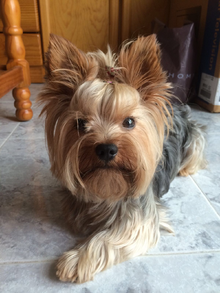

'https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Imageyorkie.png/220px-Imageyorkie.png'

yorkshire_terrier: 100.00%
havanese: 0.00%
miniature_pinscher: 0.00%
scottish_terrier: 0.00%
japanese_chin: 0.00%
chihuahua: 0.00%
saint_bernard: 0.00%
basset_hound: 0.00%
Persian: 0.00%
pomeranian: 0.00%
pug: 0.00%
keeshond: 0.00%
Maine_Coon: 0.00%
english_cocker_spaniel: 0.00%
american_pit_bull_terrier: 0.00%
samoyed: 0.00%
shiba_inu: 0.00%
leonberger: 0.00%
newfoundland: 0.00%
beagle: 0.00%
wheaten_terrier: 0.00%
Sphynx: 0.00%
Bengal: 0.00%
Bombay: 0.00%
english_setter: 0.00%
german_shorthaired: 0.00%
Birman: 0.00%
Abyssinian: 0.00%
Egyptian_Mau: 0.00%
staffordshire_bull_terrier: 0.00%
boxer: 0.00%
american_bulldog: 0.00%
British_Shorthair: 0.00%
Siamese: 0.00%
great_pyrenees: 0.00%
Ragdoll: 0.00%
Russian_Blue: 0.00%


In [52]:
from IPython.display import Image
from IPython.core.display import HTML 

predictor = CustomVisionPredictionClient(prediction_key, endpoint=prediction_endpoint)

project_id="c18c23f5-8229-4e3f-8690-c24bea88c587"
test_img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Imageyorkie.png/220px-Imageyorkie.png"
#test_img_url="https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Huddersfield_Ben.png/220px-Huddersfield_Ben.png"
#test_img_url="https://upload.wikimedia.org/wikipedia/commons/a/ab/Yorkshire_Terrier_from_1915.JPG"
#test_img_url="https://pbs.twimg.com/profile_images/504928308291592192/8zNzfTKf_400x400.jpeg"

results = predictor.predict_image_url(project_id, url=test_img_url)

display(Image(test_img_url))
display(test_img_url)

# Display the results.
for prediction in results.predictions:
    print (prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))
